In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

import ConstructPortfolio as cp #this will allow us to modularize the code!
#using "ConstructPortfolio.py" that is stored in the same directory! 
#(not using "ConstructPortfolio.ipynb")


/Users/bardiafarajnejad/Desktop/1st Half MFE/AFP/Final Delivery/MFE Group 16 AFP Code


# Trading on the "# of price targets raised/lowered" is not informative, profits at 1 day horizon which reverses at longer horizons

# Instead, it is better to follow "price_target" and trade when that moves! (on another file, I simulate this strategy as well)

In [2]:
#### Please run the line below once in order to get "data_with_rets.pkl" from "afp_data_sample_1995_onward_v2.csv"
#cp.get_data(flag=True)

data = pd.read_pickle('data_with_rets.pkl')
data.columns.values

array(['tradedate', 'osid', 'symbol', 'coname', 'sector_group', 'max_dt',
       'previoustradedate', 'tickssinceipo', 'alpha', 'stdev_alpha',
       'pricehigh', 'pricelow', 'priceclose', 'priceopen', 'splitfactor',
       'cumsplitfactor', 'volume', 'unadjustedpriceclose', 'pricepctchgd',
       'avgvol50d', 'avgdollarvol50d', 'growthscore', 'growthrank',
       'lastupdatetime', 'epsq1', 'epsq2', 'epsq3', 'epsq4', 'epsq5',
       'epsq6', 'epsq7', 'epsq8', 'epshighq1', 'epshighq2', 'epshighq3',
       'epshighq4', 'epshighq5', 'epshighq6', 'epshighq7', 'epshighq8',
       'epslowq1', 'epslowq2', 'epslowq3', 'epslowq4', 'epslowq5',
       'epslowq6', 'epslowq7', 'epslowq8', 'salesq1', 'salesq2',
       'salesq3', 'salesq4', 'salesq5', 'salesq6', 'salesq7', 'salesq8',
       'saleshighq1', 'saleshighq2', 'saleshighq3', 'saleshighq4',
       'saleshighq5', 'saleshighq6', 'saleshighq7', 'saleshighq8',
       'saleslowq1', 'saleslowq2', 'saleslowq3', 'saleslowq4',
       'saleslowq5', 's

### Now, let's trade on the times when 'numpricetargetsraised' AND 'numpricetargetslowered' >0
###### Buy when price target is raised, so when df['numpricetargetsraised']>0
###### Sell when price target is lowered, so when df['numpricetargetslowered']>0
### with 1 day, 1 week, 2 weeks, 3 weeks, and 4 weeks holding period 
### (AHEAD, not backward... so our ret, ret5d, 10d, 15d, and 20d needs to be forward)
### Thus, we will use ret5d_'lag' !!

# Set buy_tomorrow>0 when df['numpricetargetsraised']>0
# Set Sell_tomorrow>0 when df['numpricetargetslowered']>0

In [3]:
#define event using indicator for buy and sell:
data = data.sort_values(['osid', 'tradedate']).reset_index(drop=True).copy()

data = data.loc[data['numpricetargetsraised'].notna(),:].reset_index(drop=True).copy()
data = data.loc[data['numpricetargetslowered'].notna(),:].reset_index(drop=True).copy()
data = data.loc[data['numberofpricetargets'].notna(),:].reset_index(drop=True).copy()

data['buy_tomorrow'] = np.where(data['numpricetargetsraised']/data['numberofpricetargets']>0.25, 1, 0)
data['sell_tomorrow'] = np.where(data['numpricetargetslowered']/data['numberofpricetargets']>0.25, 1, 0)

data['buy_tomorrow'] = np.where(data['numpricetargetslowered']>0, 0, data['buy_tomorrow']) #DON'T BUY WHEN PRICE TARGET IS ALSO LOWERED!
data['sell_tomorrow'] = np.where(data['numpricetargetsraised']>0, 0, data['sell_tomorrow']) #DON'T SELL WHEN PRICE TARGET IS ALSO RAISED!
#ie, dont trade when there is both a price target lowered AND a price target raised !!!!!!


print('Total number of Buys: ',np.count_nonzero(data['buy_tomorrow']))
print('Total number of Sells: ',np.count_nonzero(data['sell_tomorrow']))

print('Unique buy_tomorrow values: ',np.unique(data['buy_tomorrow'])) #there is at least one '2' that occurs, which means that one stock was included in 2 indices in one day!
print('Unique sell_tomorrow values: ',np.unique(data['sell_tomorrow'])) #there is at least one '2' that occurs, which means that one stock was removed from 2 indices in one day!




Total number of Buys:  430318
Total number of Sells:  150378
Unique buy_tomorrow values:  [0 1]
Unique sell_tomorrow values:  [0 1]


In [4]:
data = cp.trade_on_valid_lags_only(data)


There are  3  problems for buying

There are  3  problems for selling
Total number of Buys:  430315
Total number of Sells:  150375


# Now we can trade!
### Holding period of 1 week, 2 weeks, 3 weeks, and 4 weeks with equal weighted portfolios!

# First, create daily equal weighted portfolio weights and returns (NOT AT THE WEEKLY frequency because that will mess up the implementation of the portfolio!). Problem is:

##### Think (part 1): 1st signal on Monday- want to buy on Tuesday and hold for 1 week in an equal weighted portfolio
##### Think (part 2): 2nd signal on Thursday- want to buy on Friday and hold for 1 week in an equal weighted portfolio
##### Think (part 3): Will have overlapping portfolio between 1st and 2nd signal on Friday and on Monday

## Then, for 1 week, 2 week, 3 week, and 4 week holding periods, we must do the following:
##### extend "buy_tomorrow" and "sell_tomorrow" forward for 4 more trading days

In [5]:
data_smaller,data_smaller5,data_smaller10,data_smaller15,data_smaller20 = cp.pull_signal_forward(data)

data_smaller20 = cp.trade_on_valid_lags_only(data_smaller20)
data_smaller15 = cp.trade_on_valid_lags_only(data_smaller15)
data_smaller10 = cp.trade_on_valid_lags_only(data_smaller10)
data_smaller5 = cp.trade_on_valid_lags_only(data_smaller5)
data_smaller = cp.trade_on_valid_lags_only(data_smaller)




There are  4  problems for buying

There are  6  problems for selling
Total number of Buys:  566670
Total number of Sells:  225904

There are  4  problems for buying

There are  6  problems for selling
Total number of Buys:  536990
Total number of Sells:  207539

There are  4  problems for buying

There are  5  problems for selling
Total number of Buys:  503148
Total number of Sells:  188161

There are  3  problems for buying

There are  5  problems for selling
Total number of Buys:  464419
Total number of Sells:  167650

There are  3  problems for buying

There are  3  problems for selling
Total number of Buys:  430228
Total number of Sells:  150342


# First, do 1 day holding period: data_smaller
# Next, do 5 day holding period: data_smaller5
# Next, do 10 day holding period: data_smaller10
# Next, do 15 day holding period: data_smaller15
# Next, do 20 day holding period: data_smaller20



There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     6.232
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           1.56e-06
Time:                        18:03:26   Log-Likelihood:                 13998.
No. Observations:                5053   AIC:                        -2.798e+04
Df Residuals:                    5046   BIC: 

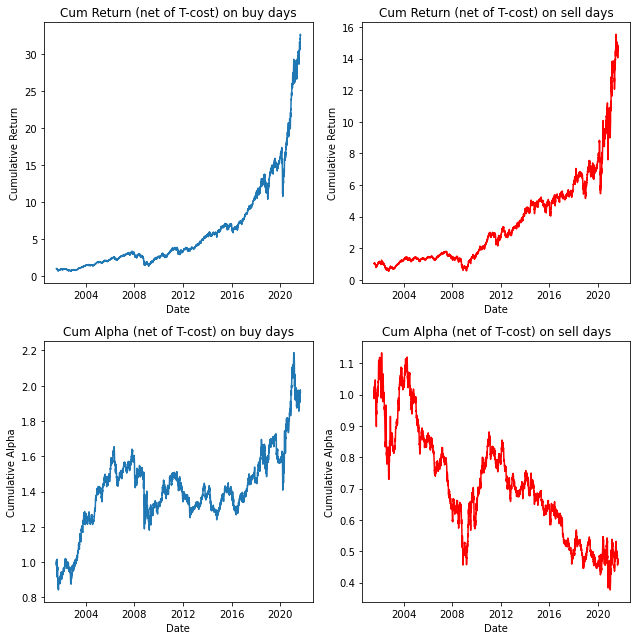

In [6]:
# 1 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller)


There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     6.467
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           8.32e-07
Time:                        18:03:57   Log-Likelihood:                 13989.
No. Observations:                5053   AIC:                        -2.796e+04
Df Residuals:                    5046   BIC: 

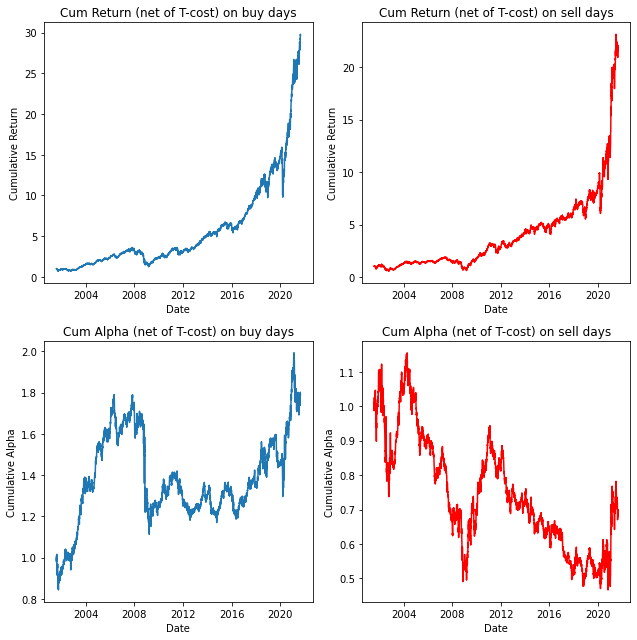

In [7]:
# 5 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller5)


There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5.892
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           3.87e-06
Time:                        18:04:32   Log-Likelihood:                 13962.
No. Observations:                5053   AIC:                        -2.791e+04
Df Residuals:                    5046   BIC: 

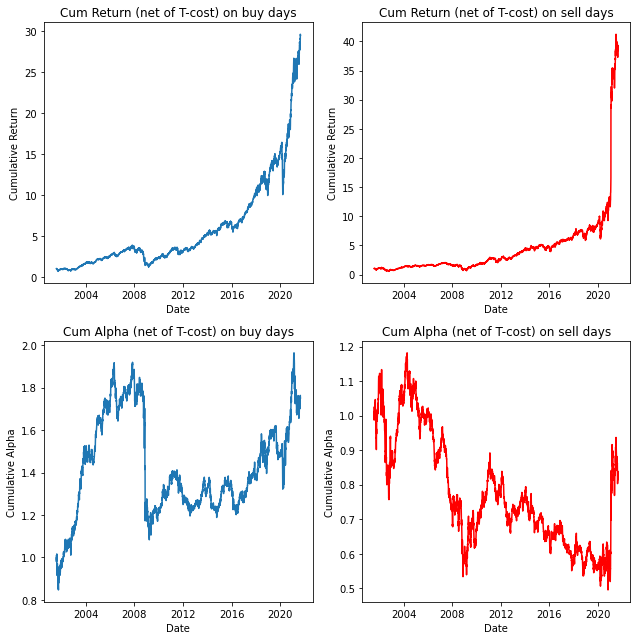

In [8]:
# 10 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller10)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.200
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           2.41e-05
Time:                        18:05:02   Log-Likelihood:                 13906.
No. Observations:                5053   AIC:                        -2.780e+04
Df Residuals:                    5046   BIC: 

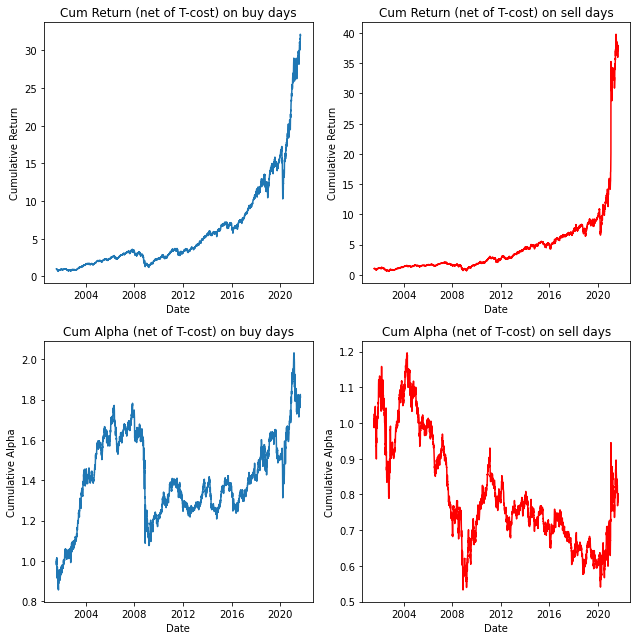

In [9]:
# 15 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller15)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5.852
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           4.30e-06
Time:                        18:05:35   Log-Likelihood:                 13937.
No. Observations:                5053   AIC:                        -2.786e+04
Df Residuals:                    5046   BIC: 

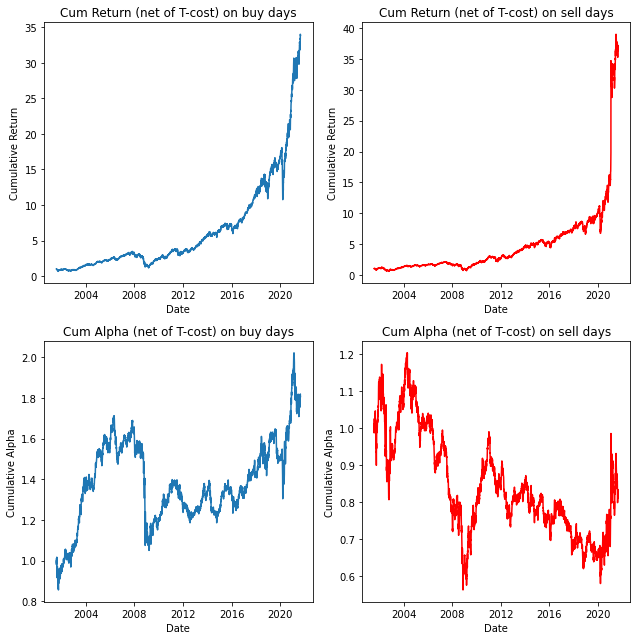

In [10]:
# 20 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller20)